In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate, configure_plot_style, AIBM_COLORS

configure_plot_style()

## Read the data

In [3]:
!ls *.csv

owid_literacy.csv		wef_primary_enrolment.csv
wef_earned_income.csv		wef_primary_enrolment_table.csv
wef_earned_income_table.csv	wef_professional_and_technical_workers.csv
wef_economic_participation.csv	wef_secondary_enrolment.csv
wef_educational_attainment.csv	wef_secondary_enrolment_table.csv
wef_labour_participation.csv	wef_tertiary_enrolment.csv
wef_legislators.csv		wef_tertiary_enrolment_table.csv
wef_literacy_rate.csv		wef_wage_equality.csv
wef_literacy_rate_table.csv	wef_wage_equality_table.csv


In [4]:
xlabel = 'Legislators, senior officials and managers percent'

In [5]:

import os
from extract_pdf_data import read_pdfs

filename = "wef_legislators.csv"
if not os.path.exists(filename):
    df = read_pdfs('legislators')
    df.to_csv(filename, index=False)

In [6]:
from utils import read_wef_file

df = read_wef_file(filename)
df.head()

,country,page_number,score,rank,diff,left,right
code,,,,,,,
ALB,Albania,83,0.518,77.0,-31.77,34.12,65.89
DZA,Algeria,85,0.091,138.0,-83.27,8.36,91.64
AGO,Angola,87,0.181,128.0,-69.28,15.36,84.64
ARG,Argentina,89,0.507,80.0,-32.71,33.65,66.35
ARM,Armenia,91,0.422,94.0,-40.69,29.65,70.35


In [7]:
df['rank'].value_counts(dropna=False).head()

rank
1.0      8
NaN      6
128.0    1
80.0     1
77.0     1
Name: count, dtype: int64

In [8]:
df['score'].describe()

count    140.000000
mean       0.538186
std        0.240266
min        0.061000
25%        0.350500
50%        0.544500
75%        0.691250
max        1.000000
Name: score, dtype: float64

In [9]:
dinged = df['score'] < 1
dinged.sum()

np.int64(132)

Here is the distribution of their scores.

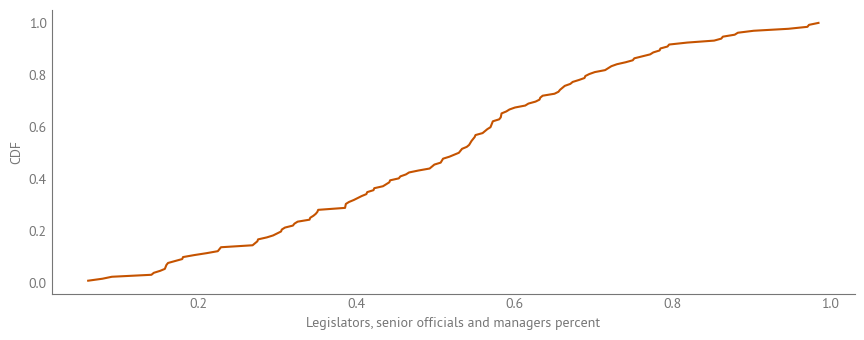

In [10]:
from empiricaldist import Cdf

cdf_score = Cdf.from_seq(df.loc[dinged, 'score'])
cdf_score.plot()
decorate(xlabel=xlabel, ylabel='CDF')

Here is the distribution of differences (female minus male in percentage points) for all countries with valid data.

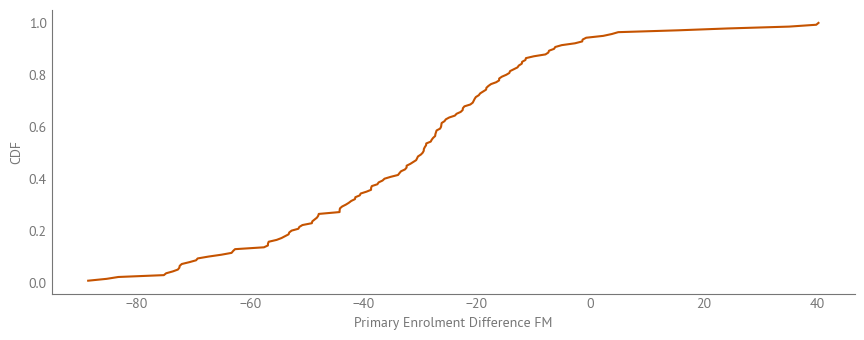

In [11]:
cdf_difference_fm = Cdf.from_seq(df['diff'])
cdf_difference_fm.plot()
decorate(xlabel='Primary Enrolment Difference FM', ylabel='CDF')

In [12]:
subset = df[dinged]
subset.sort_values("diff", ascending=False)

,country,page_number,score,rank,diff,left,right
code,,,,,,,
KEN,Kenya,225,0.985,9.0,-0.75,49.62,50.38
NER,Niger,279,0.973,10.0,-1.38,49.31,50.69
BRB,Barbados,103,0.971,11.0,-1.46,49.27,50.73
PHL,Philippines,297,0.947,12.0,-2.73,48.63,51.37
JOR,Jordan,221,0.903,13.0,-5.07,47.46,52.54
...,...,...,...,...,...,...,...
IND,India,205,0.144,136.0,-74.84,12.58,87.42
MAR,Morocco,265,0.141,137.0,-75.24,12.38,87.62
DZA,Algeria,85,0.091,138.0,-83.27,8.36,91.64


## Revised scores

The scores are based on ratios, not differences, so let's compute those.

In [13]:
df['ratio'] = df['left'] / df['right']
df['ratio'].describe()

count    140.000000
mean       0.520062
std        0.221228
min        0.060558
25%        0.350667
50%        0.532527
75%        0.671753
max        0.984915
Name: ratio, dtype: float64

Looks like the ratio IS the score.

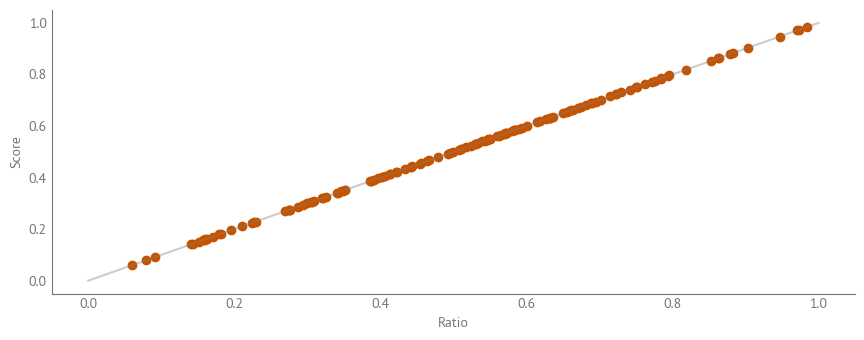

In [14]:
subset = df[dinged]
plt.plot([0, 1], [0, 1], color='gray', alpha=0.4)
plt.scatter(subset['ratio'], subset['score'])
decorate(xlabel='Ratio', ylabel='Score')

So here are the revised, symmetric scores.

In [15]:
df['revised_score'] = df['ratio']
df['revised_score'].describe()

count    140.000000
mean       0.520062
std        0.221228
min        0.060558
25%        0.350667
50%        0.532527
75%        0.671753
max        0.984915
Name: revised_score, dtype: float64

Here's the distribution of revised scores.

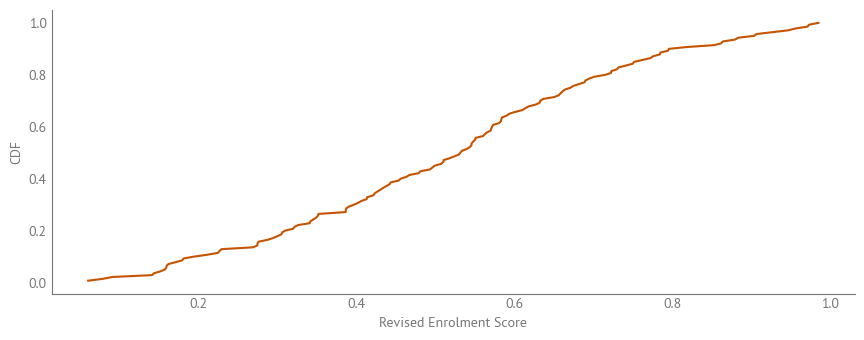

In [16]:
cdf_score = Cdf.from_seq(df['revised_score'])
cdf_score.plot()
decorate(xlabel='Revised Enrolment Score', ylabel='CDF')

Here's the distribution of revised scores, compare to the original.

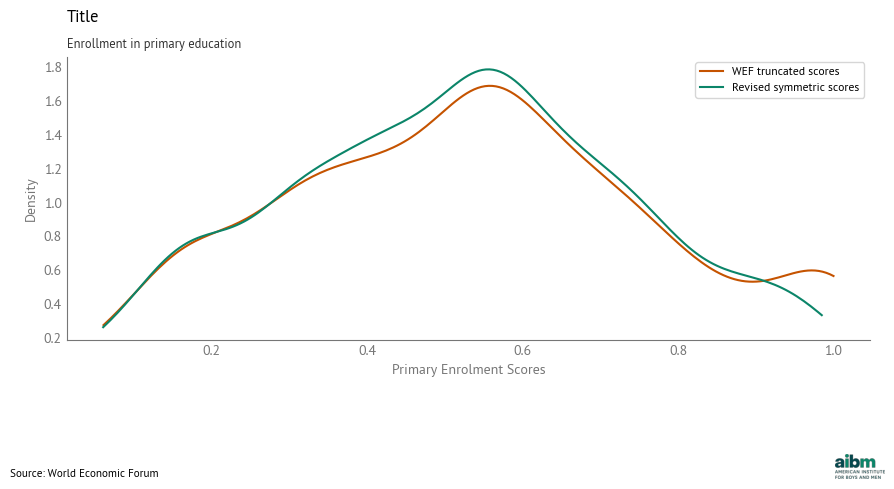

In [17]:
from utils import plot_score_distributions, add_title

plot_score_distributions(df, xlabel='Primary Enrolment Scores')
add_title("Title",
          "Enrollment in primary education")

In [18]:
revised = df[~dinged].dropna(subset=['ratio']).sort_values('revised_score')
revised.shape

(8, 9)

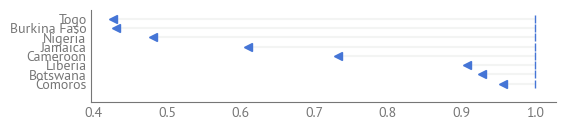

In [19]:
from utils import plot_revised_scores

plot_revised_scores(revised)

## Export the results

In [20]:
from utils import make_rank_table

table = make_rank_table(df)
table.to_csv("wef_legislators_table.csv")
table.shape

(146, 6)

In [21]:
table['score'].describe()

count    140.000000
mean       0.538186
std        0.240266
min        0.061000
25%        0.350500
50%        0.544500
75%        0.691250
max        1.000000
Name: score, dtype: float64

In [22]:
from utils import make_weight_table

make_weight_table(table, 'professional')

original             revised          
                   std   inv std       std   inv std
professional  0.240266  0.041621  0.221228  0.045202

## OECD countries

In [23]:
from utils import oecd_codes

df_oecd = df.loc[oecd_codes].sort_values(by='revised_score')

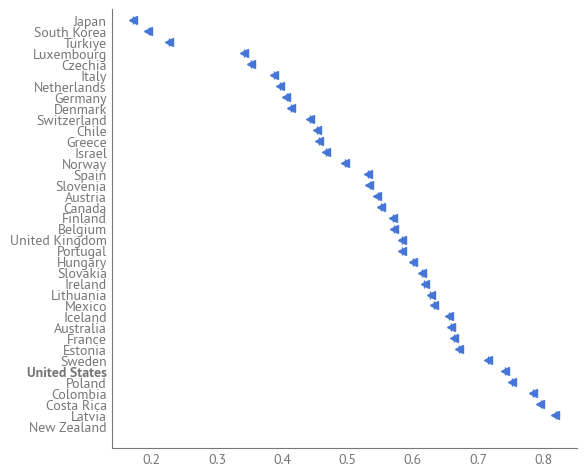

In [24]:
plot_revised_scores(df_oecd)

In [25]:
df.query("country == 'Ireland'")

,country,page_number,score,rank,diff,left,right,ratio,revised_score,revised_rank
code,,,,,,,,,,
IRL,Ireland,211,0.618,50.0,-23.61,38.2,61.8,0.618123,0.618123,46.0
